# Objective:

We are provided with a image with specific dimensions, where the model should recommend similar images of user defined N categories.

## Dataset:
Link: https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view
- The dataset provided consists of photos of various animals such as lion, tiger, cheetah,..etc.
- This dataset consists of 4738 images


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
from tqdm import tqdm

# Approach:
In order to get similar images we have two approaches.<br>
1. To cluster all the images(pixels) using unsupervised learning
2. To extract features using neural network algorithms and cluster the features using unsupervised algorithms.
<br>


**Problem with approach 1:**
- According to me the first approach would be problamatic since this only takes the color majority in pixels for clustering.
<br>**Eg:**
    - A cat which is orange and a dog which is also orange can be in a same cluster
- This will make our recommendations inaccurate.
<br><br>
Thus we rely on approach two for better recommendation of the images, since it clusters the features of a image.
Here is the below architecture for our approach.
<center><img src="https://raw.githubusercontent.com/mohit9949/Image-Similarity-Recommmendation-System/master/architecture.JPG">Our Approach</img><center>

- We will be using **ResNet50 with pretrained weights of imagenet** to extract the features. 

### ResNet50 model for feature extraction

In [21]:
def get_feature_vectors_ResNet50(model_summary=False,dataset_location=r"F:\Similar Image Finder\dataset",output_location="feature_extraction.csv"):
    # Loading the model with imagenet weights
    model=ResNet50(weights='imagenet', include_top=False, pooling='avg')
    if model_summary==True:
        print(model.summary())
    # Loading the images from the dataset
    files=[]
    for r, d, f in os.walk(dataset_location):
        for file in f:
            files.append(os.path.join(r, file))
    # Feature Extraction
    out_file=open(output_location,"w")
    feat_names=""
    for i in range(2048):
        if i==2047:
            feat_names+=str(i)
            break
        feat_names+=str(i)+","
    out_file.write('{},{}\n'.format("File Path",feat_names))
    for image_path in tqdm(files):
        # image preprocessing
        img=image_utils.load_img(image_path, target_size=(512, 512))
        img_data=image_utils.img_to_array(img)
        img_data=np.expand_dims(img_data,axis=0)
        img_data=preprocess_input(img_data)
        
        resnet50_feature = model.predict(img_data)
        # write image path and feature values as row in csv
        feat_str = [str(x) for x in resnet50_feature[0]]
        out_file.write('{},{}\n'.format(image_path, ','.join(feat_str)))
    out_file.close()
    

In [23]:
get_feature_vectors_ResNet50()


100%|██████████████████████████████████████████████████████████████████████████████| 4738/4738 [05:25<00:00, 14.58it/s]


### Features for the respective photos in a Dataset

We have saved all the features extracted into a '**.csv**' fromat for better accesibility when needed.

In [2]:
import pandas as pd
data=pd.read_csv("feature_extraction.csv")

In [3]:
data.head()

,File Path,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,F:\Similar Image Finder\dataset\0.jpg,0.003613,0.234112,0.037943,0.015738,0.311513,0.361952,0.028691,0.156090,0.006040,...,0.173987,0.219350,0.296674,0.255003,0.002904,0.099982,0.047036,0.023924,0.142812,0.135680
1,F:\Similar Image Finder\dataset\1.jpg,0.122378,0.080720,0.026997,0.109372,0.567701,0.110441,0.069890,0.037940,0.016815,...,0.025268,0.231955,0.159956,0.294382,0.009111,0.000369,0.166094,0.081325,0.009562,0.110873
2,F:\Similar Image Finder\dataset\10.jpg,0.192080,0.121319,0.008112,0.085275,0.215776,0.363319,0.000880,0.073337,0.013773,...,0.172141,0.119662,1.039665,0.963261,0.002230,0.062232,0.097369,0.462674,0.068540,0.153130
3,F:\Similar Image Finder\dataset\100.jpg,0.153012,0.077178,0.014697,0.201066,0.144666,0.195116,0.046069,0.036174,0.000678,...,0.208250,1.682768,0.024560,0.373409,0.016631,0.021253,0.000000,0.445530,0.138379,0.096600
4,F:\Similar Image Finder\dataset\1000.jpg,0.078278,0.046138,0.005151,0.039486,0.251417,0.147681,0.029872,0.031448,0.027811,...,0.046702,0.117120,0.069729,0.951183,0.007842,0.000257,0.026074,0.101593,0.003319,0.002829


**Observation:** 
- This is the dataframe which consists of image path and its respective features extracted from the module.


# Clustering with K-Means

We will be using K-Means to cluster the image features that are obtained for the given dataset.

**Issue:** The main issue with K-Means clustering is that we have to define the K hyperparameter. This will give us K clusters but we dont know how many types of animals are there in this dataset.<br><br>
**Solution:** We will be using Silhouette Score to determine the right amount of clusters from a range of them. The max silhouette score obtained from the clusters has good clustering (K) from the feature data.

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [58]:
def get_optimal_clusters(data,clusters_list=[2,3,4,5,6,7,8,9,10]):
    cluster_scores={}
    for cluster in clusters_list:
        cluster_model=KMeans(n_clusters=cluster,random_state=10)
        cluster_labels=cluster_model.fit_predict(data)
        silhouette_avg=silhouette_score(data,cluster_labels)
        print("[*] The silhouette score for {} cluster is {}\n".format(cluster,silhouette_avg))
        cluster_scores[silhouette_avg]=cluster
    best_cluster_key=max(cluster_scores.keys())
    print("** Best cluster according to silhouette score is {} with score of {} **\n".format(cluster_scores[best_cluster_key],best_cluster_key))
    return cluster_scores[best_cluster_key]

In [12]:
X=data.drop("File Path",axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.003613,0.234112,0.037943,0.015738,0.311513,0.361952,0.028691,0.156090,0.006040,0.018229,...,0.173987,0.219350,0.296674,0.255003,0.002904,0.099982,0.047036,0.023924,0.142812,0.135680
1,0.122378,0.080720,0.026997,0.109372,0.567701,0.110441,0.069890,0.037940,0.016815,0.069405,...,0.025268,0.231955,0.159956,0.294382,0.009111,0.000369,0.166094,0.081325,0.009562,0.110873
2,0.192080,0.121319,0.008112,0.085275,0.215776,0.363319,0.000880,0.073337,0.013773,0.189784,...,0.172141,0.119662,1.039665,0.963261,0.002230,0.062232,0.097369,0.462674,0.068540,0.153130
3,0.153012,0.077178,0.014697,0.201066,0.144666,0.195116,0.046069,0.036174,0.000678,0.079618,...,0.208250,1.682768,0.024560,0.373409,0.016631,0.021253,0.000000,0.445530,0.138379,0.096600
4,0.078278,0.046138,0.005151,0.039486,0.251417,0.147681,0.029872,0.031448,0.027811,0.161947,...,0.046702,0.117120,0.069729,0.951183,0.007842,0.000257,0.026074,0.101593,0.003319,0.002829


In [62]:
X.shape

(4738, 2048)

In [63]:
best_cluster=get_optimal_clusters(X)

[*] The silhouette score for 2 cluster is 0.15419901003951805

[*] The silhouette score for 3 cluster is 0.15232638997449938

[*] The silhouette score for 4 cluster is 0.1806440628839171

[*] The silhouette score for 5 cluster is 0.18015462613901853

[*] The silhouette score for 6 cluster is 0.16473310877935265

[*] The silhouette score for 7 cluster is 0.16313266954723576

[*] The silhouette score for 8 cluster is 0.1598071395458297

[*] The silhouette score for 9 cluster is 0.14669613886343208

[*] The silhouette score for 10 cluster is 0.13741290512563345

** Best cluster according to silhouette score is 4 with score of 0.1806440628839171 **



**Observation:** We got a max silhoutte score for **4 clusters.**

# Training and Clustering for K-Means
Training the K-Means model with the optimal cluster number acquired and predicting the clusters.

In [65]:
def k_means_on_dataset(X,best_cluster,data):
    from sklearn.externals import joblib
    data_frame=pd.DataFrame()
    cluster_model=KMeans(n_clusters=best_cluster,random_state=10)
    class_labels=cluster_model.fit_predict(X)
    data_frame['File path']=data['File Path']
    data_frame['labels']=class_labels
    joblib.dump(cluster_model, 'K-Means.pkl')    
    data_frame.to_csv('clustered_data.csv', index=False)
    

In [66]:
k_means_on_dataset(X,best_cluster,data)

The K-Means clustured all the features and the function stores there respective classes into a csv file name "**clustered_data.csv**"

<br>

The contents of the file are shown below.

In [7]:
data_clustured=pd.read_csv("clustered_data.csv")
data_clustured.head()

,File path,labels
0,F:\Similar Image Finder\dataset\0.jpg,0
1,F:\Similar Image Finder\dataset\1.jpg,3
2,F:\Similar Image Finder\dataset\10.jpg,3
3,F:\Similar Image Finder\dataset\100.jpg,1
4,F:\Similar Image Finder\dataset\1000.jpg,3


In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.003613,0.234112,0.037943,0.015738,0.311513,0.361952,0.028691,0.156090,0.006040,0.018229,...,0.173987,0.219350,0.296674,0.255003,0.002904,0.099982,0.047036,0.023924,0.142812,0.135680
1,0.122378,0.080720,0.026997,0.109372,0.567701,0.110441,0.069890,0.037940,0.016815,0.069405,...,0.025268,0.231955,0.159956,0.294382,0.009111,0.000369,0.166094,0.081325,0.009562,0.110873
2,0.192080,0.121319,0.008112,0.085275,0.215776,0.363319,0.000880,0.073337,0.013773,0.189784,...,0.172141,0.119662,1.039665,0.963261,0.002230,0.062232,0.097369,0.462674,0.068540,0.153130
3,0.153012,0.077178,0.014697,0.201066,0.144666,0.195116,0.046069,0.036174,0.000678,0.079618,...,0.208250,1.682768,0.024560,0.373409,0.016631,0.021253,0.000000,0.445530,0.138379,0.096600
4,0.078278,0.046138,0.005151,0.039486,0.251417,0.147681,0.029872,0.031448,0.027811,0.161947,...,0.046702,0.117120,0.069729,0.951183,0.007842,0.000257,0.026074,0.101593,0.003319,0.002829


# Utility functions for our Approach:

We create two utility functions for our pipeline to work as intended to give similar images. These function can be used seperately and integrated into web applications using python.
1. **recommend_sim_image(file,n_sample):**
 This function is used to recommend images similar to the given image. It first converts the image to a feature vector using ResNet50 and the the loaded K-Means model that we have trained predicts the cluster the image belongs to and suggest the similar images through the display function.
 
#### Parameters:
<table>
  <thead>
    <tr>
      <th>Parameters</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>file</td>
      <td>The image location given by the user. This is the base image that the function finds the similar image with.</td>
    </tr>
    <tr>
      <td>n_sample</td>
      <td>This parameter accepts integer values where its main purpose is to suggest the 'N' number of images. The default value for it is n_sample=4 so it could suggest 4 images.</td>
    </tr>
  </tbody>
</table>

2. **display_images(file,location_list,n_samples):** 
This function displays the user image and its similar image from the dataset when it's called.

#### Parameters:
<table>
  <thead>
    <tr>
      <th>Parameters</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>file</td>
      <td>The image location given by the user.</td>
    </tr>
      <tr>
      <td>location_list</td>
      <td>This accepts a list of similar image locations. Thus this is iterated in the function to display the images from the locations provided by it.</td>
    </tr>
    <tr>
      <td>n_sample</td>
      <td>This parameter accepts integer values where its main purpose is to suggest the 'N' number of images.</td>
    </tr>
  </tbody>
</table>

In [22]:
# Function to display images
def display_images(file,location_list,n_samples):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img=mpimg.imread(file)
    imgplot = plt.imshow(img)
    plt.title("User Selected Image")
    plt.show()
    # If a empty array is provided
    if location_list==[]:
        print("No similar images found")
        return 0
    figure, axes = plt.subplots(len(location_list), 1)
    print("Similar Images")
    # Quick fix for only one image in the location list
    if len(location_list)==1:
        img=mpimg.imread(location_list[0])
        imgplot = plt.imshow(img)
        plt.show()
        return 0
    # Display for multiple images
    for ax, imgname in zip(axes, location_list):
        img = plt.imread(imgname)    
        ax.imshow(img)  
        
    plt.show()

In [11]:
# Function to recommend similar images using K-Means
def recommend_sim_photos(file,n_sample=4):
    from sklearn.externals import joblib
    import os
    import warnings
    warnings.filterwarnings("ignore")
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.preprocessing import image as image_utils
    from tensorflow.keras.applications.imagenet_utils import preprocess_input
    import numpy as np
    import pandas as pd
    #preprocess the given image
    img=image_utils.load_img(file, target_size=(512, 512))
    img_data=image_utils.img_to_array(img)
    img_data=np.expand_dims(img_data,axis=0)
    img_data=preprocess_input(img_data)
    # Load the ResNet50 module and predict for the preprocessed image
    model=ResNet50(weights='imagenet', include_top=False, pooling='avg')
    resnet50_feature = model.predict(img_data) # getting the feature vector
    
    # Load our K-means model that we have trained and predict the class from the given images feature vector
    kmeans_model = joblib.load('K-means.pkl')
    pred_class=kmeans_model.predict(np.array([resnet50_feature[0]]))
    data_clustured=pd.read_csv("clustered_data.csv")
    data=data_clustured[(data_clustured['labels']==pred_class[0])]
    j=0
    # getting similar images locations with respective to n_sample given
    location_list=[]
    for i in data['File path']:
        if j==n_sample:
            break
        j+=1
        location_list.append(i)
    display_images(file,location_list,n_sample) #displaying the results
        
    

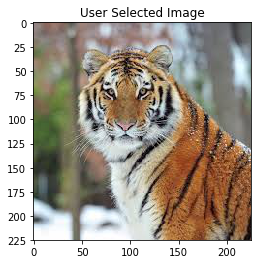

Similar Images


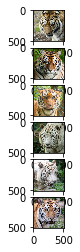

In [21]:
recommend_sim_photos(r"test/tiger.jpg", n_sample=6)

**Observation:** As we have taken the image that is seperate from our dataset from the internet to predict more accurately. This successfully predicts tigers with given n_samples.

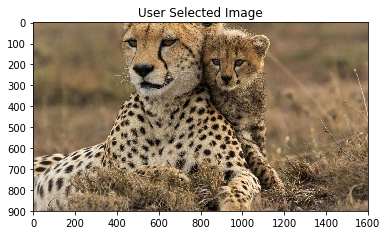

Similar Images


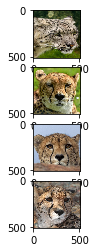

In [48]:
recommend_sim_photos(r"test/cheetah2.jpg")

**Observation:** The utility function manages to display the correct similar images for the cheetah.

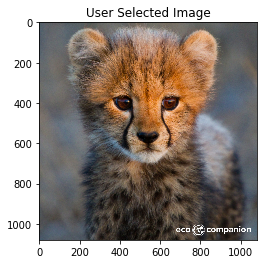

Similar Images


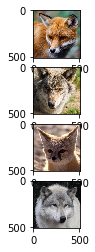

In [49]:
recommend_sim_photos(r"test/cheetah.png")

**Observations:** The cheetah cub is misclassified into a wrong cluster and different category animal images are suggested here.
- This happens since the **K-Means misclassified** the given image.
- When we dive deep we can see that the features extracted for the cheetah cub are somewhere between cheetah's and the family of canidae. Thus when you visualize this in a plane where **the cheetah cub data point is between the data point of the two clusters** where the K-Means model thinks that it belongs to the wrong cluster

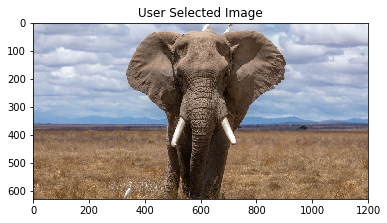

Similar Images


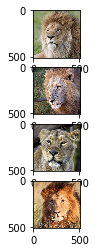

In [50]:
recommend_sim_photos(r"test/elephant.jpg")

**Observation:** Our K-means model classifies outliers like a elephant where it is not trained by our model as a lion. This shows that our model is very bad with outliers

## Conclusion from our approach:

- Our approach detects most of the classes correctly but misses with some of the animals like a cheetah cub and a outlier like elephant. 
- Also this approach has some issues like it cannot give **very similar images** to the animal given and only gives similar images that are preclassified by the model. This approach **gives static images to every animal that is classified** although it gives similar images. Thus making similarity recommendation a little bit weak.
- Also it is a bit slow since we require **two models** to predict and recommend similar images.

# Modifying our Approach

Since the problem lies in our K-means model and it does not use the benefit of the features extracted to the fullest and also it makes our recommendation a bit slow since we will be using two models we will discard it  to a better and simpler approach.
- We can find the similar images by calculating the distance between images and finding the nearest images to it. The calculation of distance is done on our feature vectors. This gives us images with similar features where the threshold of distance is our hyperparameter that we need to tune.
- This approach is similar to nearest neighbours algorithm with a magnification of distance for our feature vectors.
- To calculate the distance we will be using Cosine Similarity formula. So if there is similarity the score will be minimum and if not the similarity score maximizes.
\begin{equation*}
similarity=cos( \theta)=\frac{\sum_{i=1}^n A.B}{\sqrt{\sum_{i=1}^nA^2}*\sqrt{\sum_{i=1}^nB^2}}
\end{equation*}
**Architecture:**
<center><img src="https://raw.githubusercontent.com/mohit9949/Image-Similarity-Recommmendation-System/master/architecture2.JPG">Our Modified Approach</img><center>


# Utility functions for modified our approach:
We create three utility functions for our pipeline to work as intended to give similar images. These function can be used seperately and integrated into web applications using python.
1. **findCosineSimilarity(source_representation, test_representation):** This functions gives the cosine similariy of the given two vectors.
 
#### Parameters:
<table>
  <thead>
    <tr>
      <th>Parameters</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>source_representation</td>
      <td>It a matrix for representation of A from the above formula.</td>
    </tr>
    <tr>
      <td>target_representation</td>
      <td>It a matrix for representation of B from the above formula.</td>
    </tr>
  </tbody>
</table>


2. **recommend_sim_image_v2(file,n_sample):**
 This function is used to recommend images similar to the given image. It first converts the image to a feature vector using ResNet50 and the similarity is calculated by calling the above function to calling cosine similarity. Thus calling the display parameter after similarity matches a threshold given. In our case the **threshold is set to 0.20** after various trial and error methods.
 
#### Parameters:
<table>
  <thead>
    <tr>
      <th>Parameters</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>file</td>
      <td>The image location given by the user. This is the base image that the function finds the similar image with.</td>
    </tr>
    <tr>
      <td>n_sample</td>
      <td>This parameter accepts integer values where its main purpose is to suggest the 'N' number of images. The default value for it is n_sample=4 so it could suggest 4 images.</td>
    </tr>
  </tbody>
</table>

3. **display_images(file,location_list,n_samples):** 
This function displays the user image and its similar image from the dataset when it's called.

#### Parameters:
<table>
  <thead>
    <tr>
      <th>Parameters</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>file</td>
      <td>The image location given by the user.</td>
    </tr>
      <tr>
      <td>location_list</td>
      <td>This accepts a list of similar image locations. Thus this is iterated in the function to display the images from the locations provided by it.</td>
    </tr>
    <tr>
      <td>n_sample</td>
      <td>This parameter accepts integer values where its main purpose is to suggest the 'N' number of images.</td>
    </tr>
  </tbody>
</table>

In [4]:
def findCosineSimilarity(source_representation, test_representation):
    import numpy as np
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))


In [5]:
def recommend_sim_photos_v2(file,n_sample=4):
    import pandas as pd
    import os
    import warnings
    warnings.filterwarnings("ignore")
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.preprocessing import image as image_utils
    from tensorflow.keras.applications.imagenet_utils import preprocess_input
    import numpy as np
    #Loading features of our dataset images
    data=pd.read_csv("feature_extraction.csv")
    #preprocess the given image
    img=image_utils.load_img(file, target_size=(512, 512))
    img_data=image_utils.img_to_array(img)
    img_data=np.expand_dims(img_data,axis=0)
    img_data=preprocess_input(img_data)
    # Load the ResNet50 module and predict for the preprocessed image
    model=ResNet50(weights='imagenet', include_top=False, pooling='avg')
    resnet50_feature = model.predict(img_data) #getting our feature vectors
    j=0
    user_image_features=resnet50_feature[0].astype(float) #converting the features to float values for our distance formula to work
    location_list=[]
    for features_index in range(1,len(data)):
        if j>=n_sample:
             break
        #Finding similarity score
        sim_score=findCosineSimilarity(user_image_features,np.array(data.iloc[features_index,1:]).astype(float))
        if sim_score<0.20: #Threshold comparison for our similarity score
            j+=1
            location_list.append(data.iloc[features_index,0])
    display_images(file,location_list,n_sample)
            
            

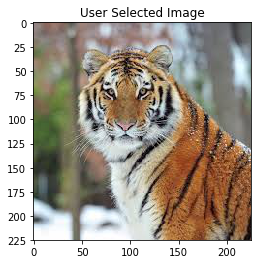

Similar Images


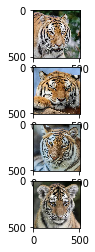

In [53]:
recommend_sim_photos_v2(r"test/tiger.jpg")

**Observation:** The tiger recommendation is on point with succesfull recommendation of similar images.

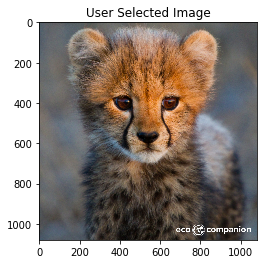

Similar Images


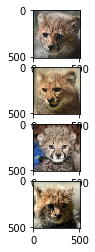

In [54]:
recommend_sim_photos_v2(r"test/cheetah.png")

**Observation:** The cheetah cub recommendation is on point with succesfull recommendation of similar images.

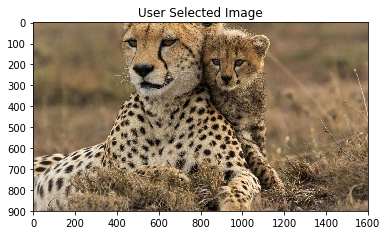

Similar Images


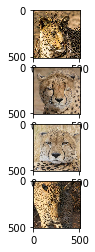

In [8]:
recommend_sim_photos_v2(r"test/cheetah2.jpg")

**Observation:** The cheetah recommendation is on point with succesfull recommendation of similar images.

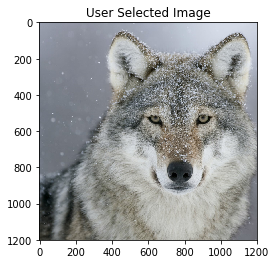

Similar Images


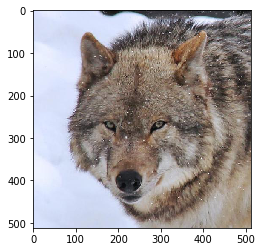

In [16]:
recommend_sim_photos_v2(r"test/wolf.jpg")

**Observation:** This example of wolf image and its recommendation tells that our modified approach is working too good. 

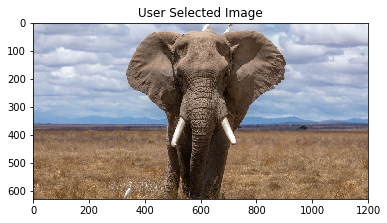

No similar images found


In [14]:
recommend_sim_photos_v2(r"test/elephant.jpg")

**Observation:** The elephant is not present in our dataset and thus no similar images where found.

# Conclusion:

- First we developed a **ResNet model and a K-Means model** for similar image recommendation. The recommendations where **good but had some flaws** while detecting some images like elephants, cheetah cubs where the features are not present or where the features of the image are not that strong.
- We modified our pipeline with **discarding the K-Means** model and only using a distance function to calculate the features, measuring their distance. The shortest distance images from the given image are recommended from our dataset.
- The distance function used here is **Cosine Similarity**
- From the above examples we can see that our recommendations are better than our first approach and the processing is also fast when compared with our first approach. 
- The second approach utility functions can be used anywhere for the recommendation of images.